# 18_Mask man 2

Test
Train
Validation
With Mask :  5909
Without Mask :  5883


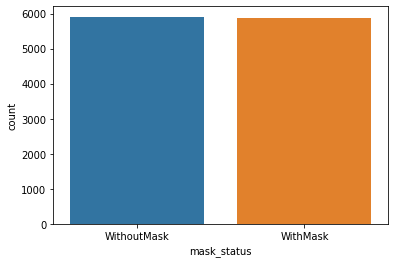

In [1]:
import sys
import numpy as np
import pandas as pd
import os
import glob
        # Return a list of paths matching a pathname pattern.
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------# 

import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# --------------------------------------------------#
path = './dataset/Face Mask Dataset/'
dataset = {'image_path' : [], 'mask_status' : [], 'where': []}

for where in os.listdir(path):      # test / train / validation
    print(where)
    for status in os.listdir(path + '/' + where):       # withmask / withoutmask
        
        for image in glob.glob(path + where + '/' + status + '/' + '*.png'):
            dataset['image_path'].append(image)
            dataset['mask_status'].append(status)
            dataset['where'].append(where)


## .ds_store 해결 : find . -name "*.DS_Store" -type f -delete           << cmd


# ---------------------------------------------------#
dataset = pd.DataFrame(dataset)
dataset.head()

# ---------------------------------------------------# 

print('With Mask : ', dataset.value_counts('mask_status')[0])
print('Without Mask : ', dataset.value_counts('mask_status')[1])

sns.countplot(x=dataset['mask_status']);

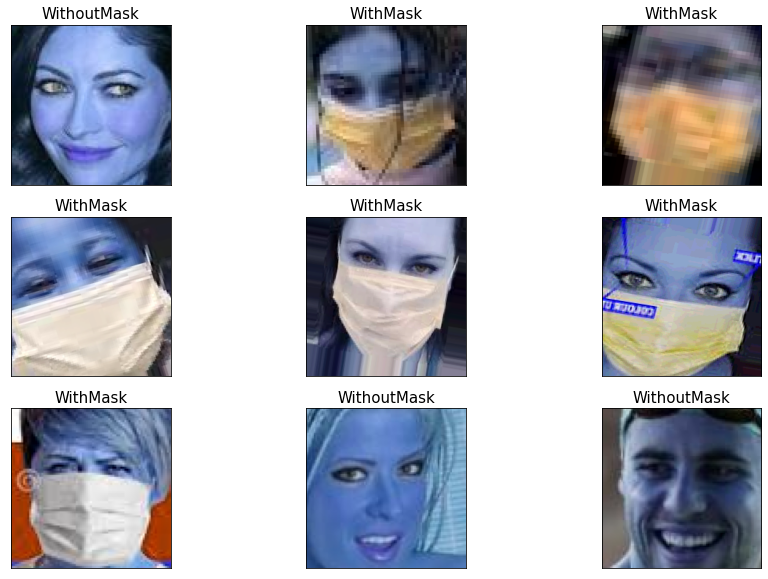

In [4]:
# 랜덤하게 어떤 그림들이 있는지 보기
import cv2

plt.figure(figsize=(15,10))
for i in range(9):
    random = np.random.randint(1, len(dataset))
                        # randint : 난수를 정수로 변환함.
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.imread(dataset.loc[random, 'image_path']))
    plt.title(dataset.loc[random, 'mask_status'], size=15)
    plt.xticks([])
    plt.yticks([])

plt.show()

In [5]:
train_df = dataset[dataset['where'] == 'Train']
test_df = dataset[dataset['where'] == 'Test']
valid_df = dataset[dataset['where'] == 'Validation']

train_df.head(5)

,image_path,mask_status,where
992,./dataset/Face Mask Dataset/Train/WithoutMask/...,WithoutMask,Train
993,./dataset/Face Mask Dataset/Train/WithoutMask/...,WithoutMask,Train
994,./dataset/Face Mask Dataset/Train/WithoutMask/...,WithoutMask,Train
995,./dataset/Face Mask Dataset/Train/WithoutMask/...,WithoutMask,Train
996,./dataset/Face Mask Dataset/Train/WithoutMask/...,WithoutMask,Train


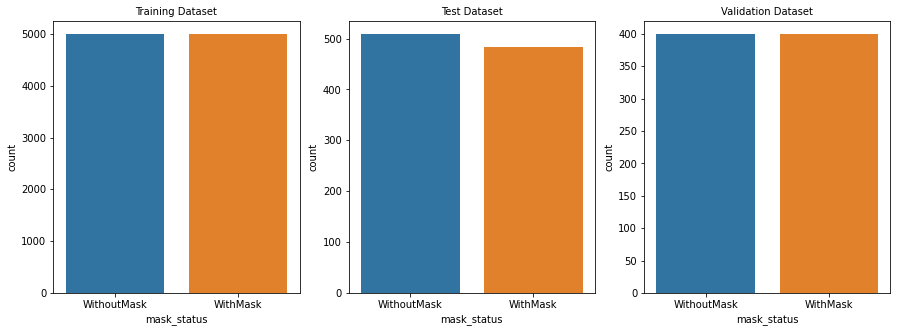

In [7]:
# Train / test / validation 데이터의 분포 확인
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x = train_df['mask_status'])
plt.title('Training Dataset', size=10)

plt.subplot(1, 3, 2)
sns.countplot(x=test_df['mask_status'])
plt.title('Test Dataset', size=10)

plt.subplot(1, 3, 3)
sns.countplot(x=valid_df['mask_status'])
plt.title('Validation Dataset', size=10)

plt.show()

In [8]:
# index를 다시 정리
train_df = train_df.reset_index().drop('index', axis =1 )
train_df.head()

,image_path,mask_status,where
0,./dataset/Face Mask Dataset/Train/WithoutMask/...,WithoutMask,Train
1,./dataset/Face Mask Dataset/Train/WithoutMask/...,WithoutMask,Train
2,./dataset/Face Mask Dataset/Train/WithoutMask/...,WithoutMask,Train
3,./dataset/Face Mask Dataset/Train/WithoutMask/...,WithoutMask,Train
4,./dataset/Face Mask Dataset/Train/WithoutMask/...,WithoutMask,Train


In [9]:
# pre-processing
data = []
image_size = 150

for i in range(len(train_df)):
    # Converting the image into grayscale
    img_array = cv2.imread(train_df['image_path'][i], cv2.IMREAD_GRAYSCALE)
                                                            # 이미지를 읽어올 때, grayscale 로 불러온다.

    # Resizing the array
    new_image_array = cv2.resize(img_array, (image_size, image_size))
                            # resize : A 이미지를 (x,x) 사이즈로 변경
                                # object
                                            # (x,y) 사이즈

    # Encoding the image with the label
    if train_df['mask_status'][i] == 'WithMask':
        data.append([new_image_array, 1])
                    # new_image_array : np.array 타입임. 따라서 해당 밸류가 리스트에 들어가게 되면, [[new_image_array], 1] 의 형식으로 들어가게 된다.
    else:
        data.append([new_image_array, 0])

In [15]:
data[0]

[array([[19, 20, 21, ..., 29, 29, 28],
        [19, 21, 22, ..., 26, 24, 21],
        [20, 21, 21, ..., 22, 21, 19],
        ...,
        [18, 18, 18, ..., 25, 26, 24],
        [16, 17, 18, ..., 25, 29, 33],
        [16, 19, 20, ..., 24, 34, 46]], dtype=uint8),
 0]

In [16]:
# 데이터 shuffle

np.random.shuffle(data)

In [17]:
data[0]

[array([[ 40,  48,  45, ...,  31,  30,  30],
        [ 39,  47,  46, ...,  27,  26,  24],
        [ 38,  46,  47, ...,  22,  21,  19],
        ...,
        [208, 207, 206, ...,  28,  31,  34],
        [205, 205, 204, ...,  26,  31,  34],
        [202, 201, 201, ...,  27,  29,  32]], dtype=uint8),
 1]

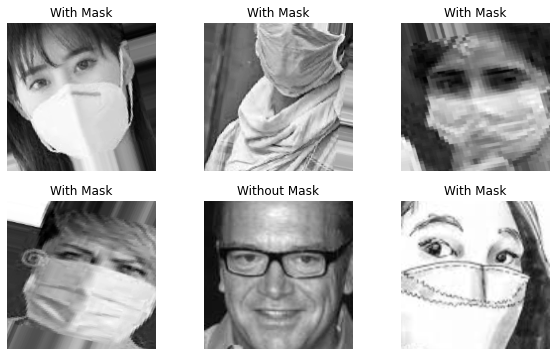

In [18]:
# 검증하기
fig, ax = plt.subplots(2, 3, figsize=(10,6))

for row in range(2):
    for col in range(3):
        image_index = row * 100 + col

        ax[row, col].axis('off')
        ax[row, col].imshow(data[image_index][0], cmap='gray')

        if data[image_index][1] == 0:       # label의 값이 0 이면 without mask
            ax[row, col].set_title('Without Mask')

        else:
            ax[row, col].set_title('With Mask')

In [19]:
# X, y 데이터로 저장
X = []      # 이미지 feature    
y = []      # 이미지 label

for image in data:
    X.append(image[0])
    y.append(image[1])


## tensorflow 에서 오동작 하지 않도록 np.array() 함.
X = np.array(X)
y = np.array(y)

In [21]:
# 트레인 데이터 다시 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

## 이전에는 test 데이터를 받아왔는데, 왜 validate 데이터를 받기로 한걸까? >> 다음 시간